# Evaluation of Molecular Dynamics Named Entities Recognition (MDNER)

The objective of this notebook is to evaluate our MDNER obtained with [SpaCy v3](https://spacy.io/) by evaluate the annotated entities, the different models and their performance. 

## Prerequise packages

In [1]:
import pandas as pd
import spacy
from matplotlib import pyplot as plt
import os
import seaborn as sns
import json
import glob
import re
import sys
sys.path.append('../scripts')
import evaluate_ner as evner

## Corpus composition

The evaluation of the distribution of entities in our corpus will allow us to identify the most and least abundant entities.

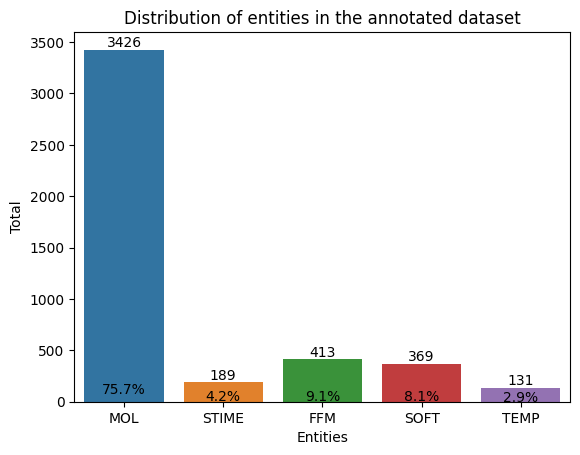

In [2]:
path = "../annotations/"
name_ents = ["MOL", "STIME", "FFM", "SOFT", "TEMP"]
n_ents = {label: 0 for label in name_ents}
total = 0

# Get numbers and percentage for each entity
for json_name in glob.glob(path + "*.json"):
    with open(json_name) as json_file:
        annotations = json.load(json_file)["annotations"][0][1]
        for _, _, label in annotations["entities"]:
            n_ents[label] += 1
            total += 1

# Create a pandas DataFrame with the percentage and total number of sample entities.
df = pd.DataFrame.from_dict(
    {"Percentage": {label: n_ents[label] / total * 100 for label in name_ents},
     "Total": n_ents}
)

# Display a bar plot for each entity
ax = sns.barplot(x=df.index, y='Total', data=df)
plt.xlabel("Entities")
plt.title("Distribution of entities in the annotated dataset")

# Add the number of sample entities and a percentage for each dedicated bar
for i, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height(),
            f"{int(df.iloc[i]['Total'])}",
            ha='center',
            va='bottom')
    ax.text(i, df.iloc[i]['Percentage'] + 1,
            f"{df.iloc[i]['Percentage']:.1f}%",
            ha='center')

As shown in the figure above, there is a large number of "MOL" (molecules) entities which represent more than 76% of all entities. The entities "STIME" (simulation time) and "TEMP" (temperature) are less present in the corpus with a percentage of 4.2% and 2.9% respectively. 

In order to learn each entities, more than 100 entities samples must be present. In our case, this condition is correct.

The distribution of these entities allows us to say that the NER should expect an overrepresentation of the entitie "MOL" in a text compared to the entities "STIME" and "TEMP" for example.

We then split our dataset into 3 parts with 75% of the data for the training (251 in total), 15% of the data for the testing (55 in total) and 10% of the data for the evaluation (35 in total).  

## Naive SpaCy model vs. model with a Transformers-type architecture 

In order to obtain the best possible model, we have looked to create different models. We first created two types of models, a statistical model proposed by SpaCy and a model with a Transformers type architecture. Note here that the vectorisation of tokens by the naive model is based on the use of tok2vec. 

In order to evaluate the performance of our models, we will base on 3 metrics, namely the precision score, the recall score and the f1 score:
* Precison score tells us that the model predicts correctly but not everything.
* Recall score tells us that the model predicts many entities but not necessarily correct.
* F1 score is a [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of the precision score and the recall score.

These scores are obtained with the help of a confusion matrix and using the formulas available [here](https://en.wikipedia.org/wiki/F-score).
For the evaluation of our model, we will use the precision score as we prefer quality to quantity.

The hyperparameters used to design these models are: 
* *Batch size* of 32
* *Learning rate* of 0.001
* For the model with a Transformers-type architecture, we choose to fine-tune a model which is [*allenai/biomed_roberta_base*](https://huggingface.co/allenai/biomed_roberta_base)

### During the training

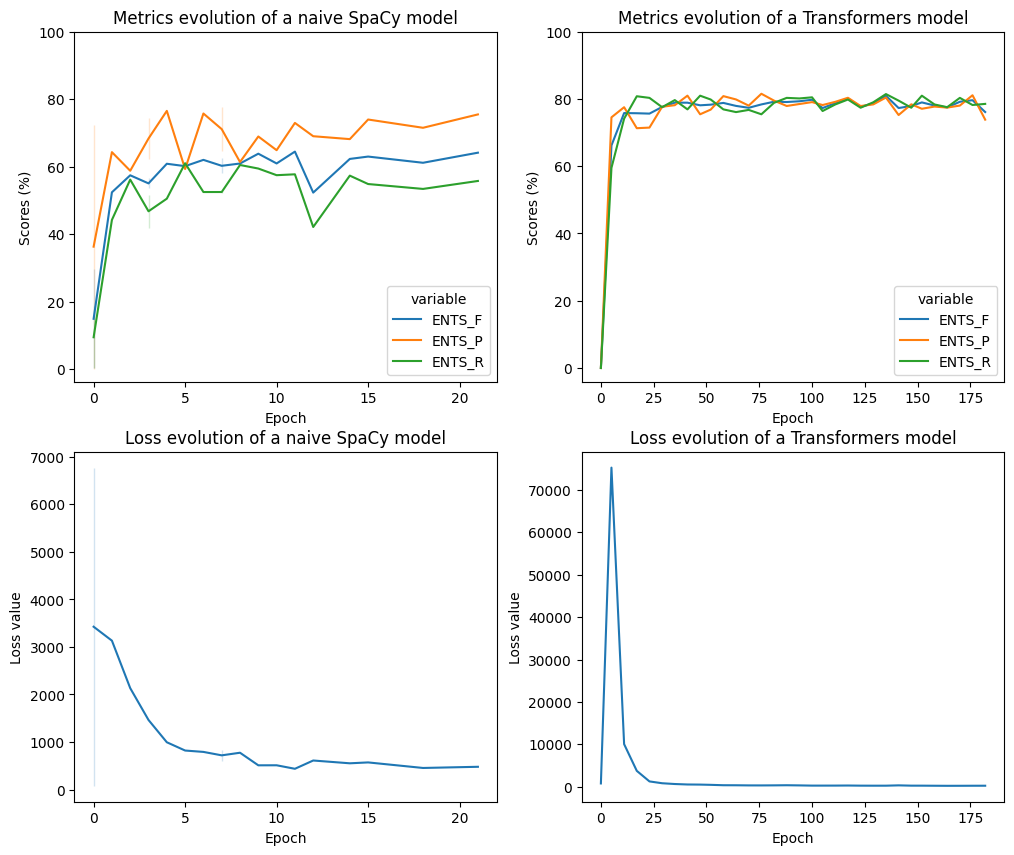

In [2]:
paths = ["../results/models_0.1_1.0_0.0_0.0/metrics_train.txt", "../results/colab/all_ents/metrics_train.txt"]
names_model = ["a naive SpaCy model", "a Transformers model"]
results = evner.get_scores(paths)
evner.display_plots(results, names_model)

From the figures above, we can see that the model with a Transfromers performs better during training. Indeed, all the metrics of the Transformers model are around 80%, whereas the metrics of the naive model are less good. The precision score is around 75%, the recall score is lower with a score of around 50%. We note a difference in the loss value with a better loss value with the Transformers model.

### Benchmark with the evaluation data

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
!python -m spacy benchmark accuracy ../results/models_0.1_1.0_0.0_0.0/model-best/ ../results/outputs/eval_data.spacy
!python -m spacy benchmark accuracy ../results/colab/all_ents/models/model-best/ ../results/outputs/eval_data.spacy

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK     100.00
NER P   65.18 
NER R   48.23 
NER F   55.43 
SPEED   5825  


=============================== NER (per type) ===============================

            P       R       F
FFM     58.49   58.49   58.49
MOL     69.38   48.01   56.75
TEMP    45.45   45.45   45.45
SOFT    68.18   34.09   45.45
STIME   44.44   61.54   51.61

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK     100.00
NER P   82.38 
NER R   81.80 
NER F   82.09 
SPEED   661   


=============================== NER (per type) ===============================

            P       R       F
FFM     86.96   75.47   80.81
MOL     84.26   85.10   84.68
SOFT    74.36   65.91   69.88
TEMP    66.67   90.91   76.92
STIME   66.67   76.92   71.43



We then tested the two models on a dataset that was not used for the training. The output illustrates what has been said before,  i.e. that the Transformers model performs better. The precision score obtained with the naive model is 65% and the precision score obtained with the Transformers model is 82%.

Thus, through the evaluation of these models, we have chosen to take the Transformers model which has better results.

## Models on the MOL entity

For the next part of the model building, we have chosen to compare two models, namely a model with only the MOL entity and a model with all entities. The MOL entity corresponds to the most important entity, which is why we create a specific model for this entity. We want to verify that the model with only MOL entity has a better performance in terms of classification.

### During the training

In [ ]:
paths = ["../results/colab/only_mol/metrics_train.txt", "../results/colab/all_ents/metrics_train.txt"]
names_model = ["only MOL model", "all entities model"]
results = evner.get_scores(paths)
evner.display_plots(results, names_model)

When create the models, the resulting model metrics are better on the model with only MOL entities with a difference about 4% for the precision score, 7% for the recall score and 5% for the f1 score. It cannot be generalised because the evolution of the metrics of the all entities model is an average of all entities, so it's necessary to test with the validation dataset and evaluate the model focused in the MOL entity. 

### Benchmark with the evaluation data

In [5]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
!python -m spacy benchmark accuracy ../results/colab/only_mol/models/model-best/ ../results/colab/only_mol/eval_data.spacy
!python -m spacy benchmark accuracy ../results/colab/all_ents/models/model-best/ ../results/colab/all_ents/eval_data.spacy

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK     100.00
NER P   85.62 
NER R   86.75 
NER F   86.18 
SPEED   656   


=============================== NER (per type) ===============================

          P       R       F
MOL   85.62   86.75   86.18

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK     100.00
NER P   82.38 
NER R   81.80 
NER F   82.09 
SPEED   682   


=============================== NER (per type) ===============================

            P       R       F
FFM     86.96   75.47   80.81
MOL     84.26   85.10   84.68
SOFT    74.36   65.91   69.88
TEMP    66.67   90.91   76.92
STIME   66.67   76.92   71.43



According to the output below, the scores are not very different. Indeed, looking only at the MOL entity, we have a precision score of 85.62% and 84.26% for the "only MOL" model and the "all entities" model respectively. This difference may be insignificant.

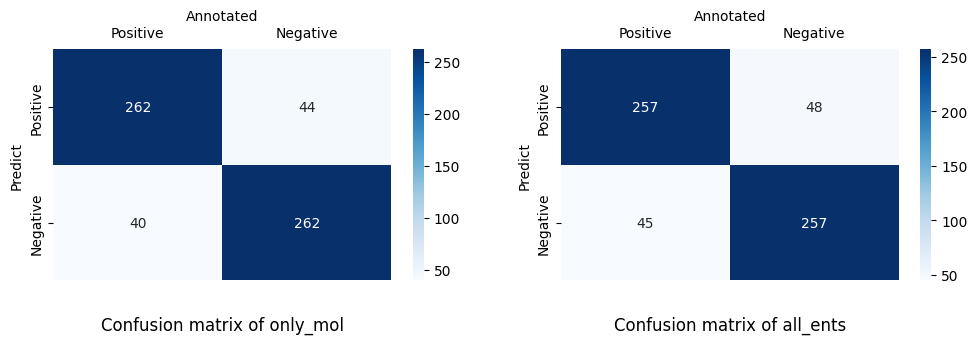

In [3]:
# Get confusion matrix and scores for each models
names_model = ["only_mol", "all_ents"]
cf_mtx, scores = {}, {}
for name_model in names_model:
    cf_mtx[name_model], scores[name_model] = evner.get_confusion_matrix(name_model, True)

# Display confusion matrix of each models 
evner.display_confusion_matrix(cf_mtx, names_model)

These confusion tables illustrate more precisely the difference between the two models on the molecule entities. The difference between the number of false positives (predicted as molecules but not annotated as molecules) is negligible (we are at 4 annotated entities difference). The same is true for the number of false negatives (predicted to be something else but is actually a molecule).

## Entity Rulers

In order to maximise our chances to obtain the best possible model, we looked at Entity Rulers.

The [Entity Rulers](https://spacy.io/api/entityruler) can be useful if the corpus on which the model has been trained does not cover all the entities we are interested in, or if we wish to improve the performance of the model on a specific subset of entities, namely molecules. 

We listed a set of molecule names from the [PubChem](https://pubchem.ncbi.nlm.nih.gov/) database and defined them as our patterns for our Entity Rulers.  We have studied the performance with and without Entity Rulers as illustrated in the figures:

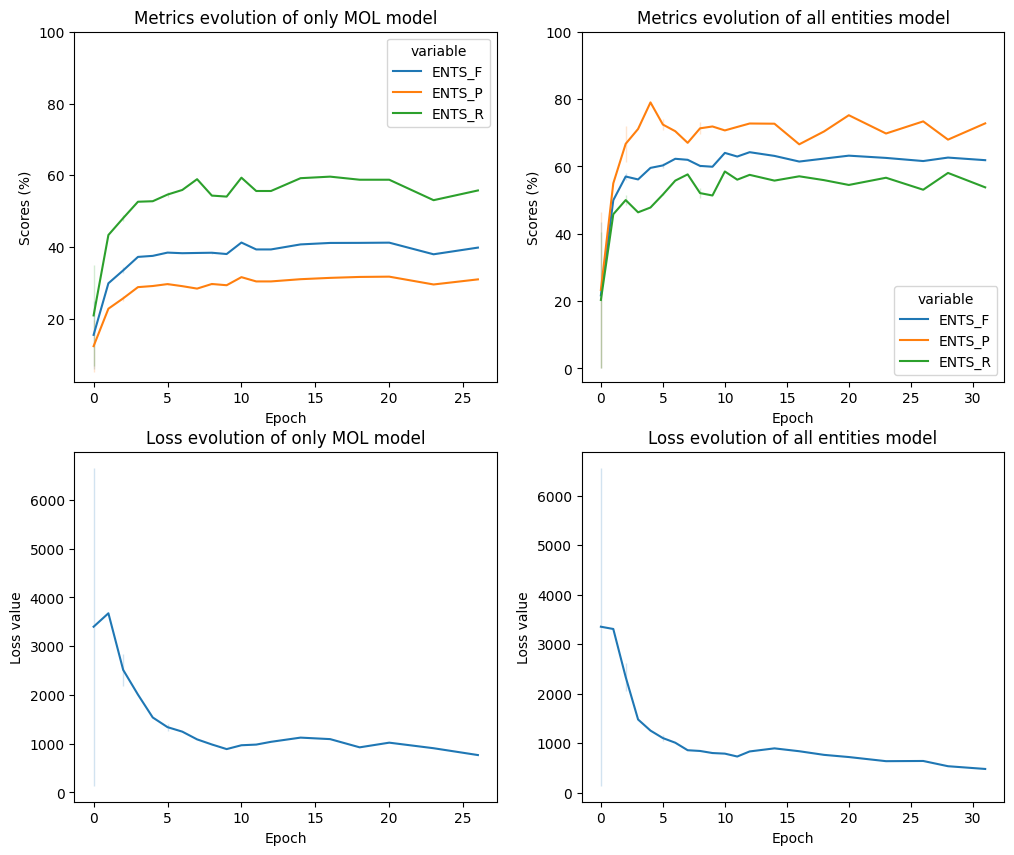

In [24]:
paths = ["../results/cpu_with_rulers.txt", "../results/cpu_without_rulers.txt"]
results = get_scores(paths)
display_plots(results)

In [13]:
bench_without = "MOL     51.96   64.63   57.61"
bench_with = "MOL      66.37   45.73   54.15"
pd.DataFrame([[66.37, 51.96]], columns=["Without rulers", "With rulers"], index=["MOL"])

,Without rulers,With rulers
MOL,66.37,51.96


We note a difference in the metrics during training. Indeed, it's important to note that the entity rules can sometimes lead to conflicts with the information learned by the model, which can result in poorer performance. It's important to carefully test and evaluate the effect of adding these entity rules on the performance of the model before using them.

## NER vs regular expression

The objective of this part is to compare our model using all entities with regular expressions, more precisely for entities like "STIME" (simulation time) and "TEMP" (temperature) which are easy to extract.

In [14]:
pattern = r"(\d+\.\d+|\d+)\s*([nμm]s)"
path = "../results/colab/all_ents"
ner = spacy.load(path + "/models/model-best/")
nlp = spacy.blank("en")
regex_time = 0
matchs_regex = []
ner_time = 0
matchs_ner = []
true_time = 0
annotated = []

# Read the evaluation dataset
with open(path + "/eval_data.spacy", "rb") as f:
    doc_bin = spacy.tokens.DocBin().from_bytes(f.read())
    
# Get predicted entities and annoted entities
for doc in doc_bin.get_docs(nlp.vocab):
    doc_ner = ner(doc.text)
    matchs = re.findall(pattern, doc.text)
    matchs_regex.extend(matchs)
    regex_time += len(matchs)
    pred_ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc_ner.ents if ent.label_ == "STIME"]
    matchs_ner.extend(pred_ents)
    ner_time += len(pred_ents)
    true_ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents if ent.label_ == "STIME"]
    annotated.extend(true_ents)
    true_time += len(true_ents)
print("NER: ", matchs_ner, "\n")
print("REGEX: ", matchs_regex, "\n")
print("ANNOTATED: ", annotated, "\n")
print("[STIME with NER]:", ner_time, " [STIME with REGEX]:", regex_time, " [STIME annotated]:", true_time)

NER:  [('149 ns', 630, 636, 'STIME'), ('microsecond', 660, 671, 'STIME'), ('10 μs', 758, 763, 'STIME'), ('1 microsecond', 449, 462, 'STIME'), ('100ns', 1302, 1307, 'STIME'), ('microsecond', 642, 653, 'STIME'), ('200 ns', 677, 683, 'STIME'), ('1.6 μs', 723, 729, 'STIME'), ('20', 795, 797, 'STIME'), ('10 µs', 802, 807, 'STIME'), ('sub-millisecond', 470, 485, 'STIME'), ('200ns', 824, 829, 'STIME'), ('200ns', 327, 332, 'STIME'), ('Hundred nanosecond', 0, 18, 'STIME'), ('one hundred nanosecond', 157, 179, 'STIME')] 

REGEX:  [('149', 'ns'), ('41', 'ns'), ('10', 'μs'), ('100', 'ns'), ('200', 'ns'), ('1.6', 'μs'), ('200', 'ns'), ('200', 'ns'), ('200', 'ns')] 

ANNOTATED:  [('149 ns.', 630, 637, 'STIME'), ('microsecond', 660, 671, 'STIME'), ('10 μs', 758, 763, 'STIME'), ('1 microsecond', 449, 462, 'STIME'), ('100ns', 1302, 1307, 'STIME'), ('microsecond', 642, 653, 'STIME'), ('0.6', 719, 722, 'STIME'), ('1.6 μs', 723, 729, 'STIME'), ('20', 795, 797, 'STIME'), ('10 µs', 802, 807, 'STIME'), ('6µs

## Annex

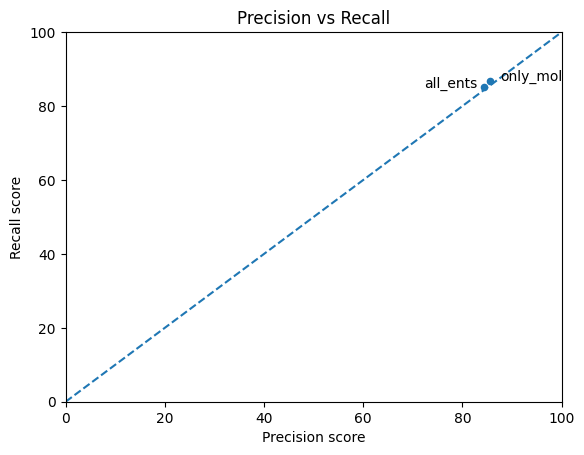

In [4]:
name_models = ["only_mol", "all_ents"]
pscores = [scores[model][0] for model in name_models]
rscores = [scores[model][1] for model in name_models]
df = pd.DataFrame({"x":pscores, "y":rscores, "model":name_models})

# Plot different scores
ax = df.plot(kind='scatter', x='x', y='y')
plt.title("Precision vs Recall")
plt.plot([0, 100], [0, 100], linestyle="dashed")
plt.ylim(0, 100)
plt.xlim(0, 100)
plt.xlabel("Precision score")
plt.ylabel("Recall score")

# Label each point in scatter plot
for idx, row in df.iterrows():
    if idx == 1:
        ax.annotate(row['model'], (row['x'] - 12, row['y']))
    else :
        ax.annotate(row['model'], (row['x'] + 2, row['y']))

In [53]:
#--------------------------------------------OUTPUTS--------------------------------------------#

benchmark_command_mol = """ MOL   77.07   76.58   76.83 """
benchmark_command_all = """
================================== Results ==================================

TOK     100.00
NER P   73.55 
NER R   71.20 
NER F   72.36 
SPEED   3554  


=============================== NER (per type) ===============================

             P       R       F
MOL      69.59   75.32   72.34
SOFT     95.00   61.29   74.51
FFM      83.87   59.09   69.33
STIME    45.45   83.33   58.82
TEMP    100.00   81.82   90.00
"""

<Figure size 500x500 with 0 Axes>

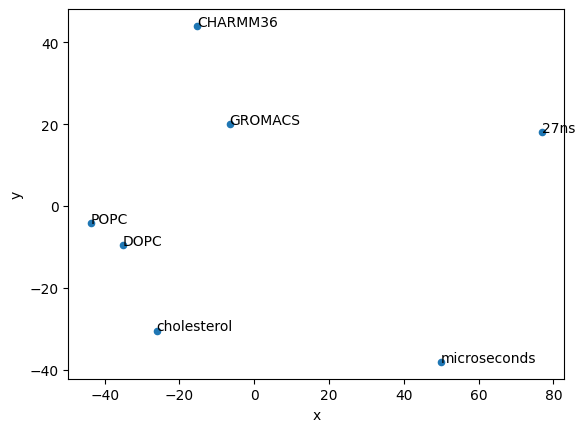

In [39]:
import numpy as np
import spacy
from sklearn.decomposition import PCA

nlp = spacy.load("../results/models_0.4_0.0_0.5_0.5/model-best/")

animals = """POPC DOPC cholesterol GROMACS CHARMM36 microseconds 27ns"""
tokens = nlp(animals)
vocab = animals.split()
vectors = np.vstack([word.vector for word in tokens])

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(vectors)
embeddings_df = pd.DataFrame({"x":embeddings_2d[:, 0], "y":embeddings_2d[:, 1], "token":vocab})

fig = plt.figure(figsize=(5, 5))

x_axis = embeddings_2d[:, 0]
y_axis = embeddings_2d[:, 1]

ax = embeddings_df.plot(kind='scatter', x='x', y='y')

#label each point in scatter plot
for idx, row in embeddings_df.iterrows():
    ax.annotate(row['token'], (row['x'], row['y']))